# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- nltk 3.7
- keras 2.9.0
- tensorflow 2.9.1


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Esta es la función que usaremos para generar datos (muestreo desde Z)

In [2]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Definimos el encoder del VAE (es un VAE convolucional)

-- filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

-- kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

-- strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs) 
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 16)     4624        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['conv2d_3[0][0]']               
                                                                                            

### Ahora definimos el decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 16))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 784)               2352      
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       4640      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        577 

### El VAE se define acoplando ambos modelos (encoder y decoder). Definimos además la función de pérdida, y el train step. Usamos un reduce mean para calcular el error de reconstrucción. Se usa una pérdida KL para ajustar la Gaussiana. 

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Vamos a trabajar sonre digits

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

### Vamos a usar todos las datos para preentrenar. Esto es aprendizaje no supervisado. Vamos a usar 30 epochs, y batch size = 128. Estos hiperparámetros podemos modificarlos. Vamos a monitorear ambas pérdidas (reconstrucción y KL)

In [10]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 22s 39ms/step - loss: 154.7216 - reconstruction_loss: 148.6721 - kl_loss: 5.7695
Epoch 2/30
547/547 [==============================] - 21s 39ms/step - loss: 154.2299 - reconstruction_loss: 148.1193 - kl_loss: 5.8235
Epoch 3/30
547/547 [==============================] - 21s 39ms/step - loss: 153.5945 - reconstruction_loss: 147.7374 - kl_loss: 5.8446
Epoch 4/30
547/547 [==============================] - 22s 40ms/step - loss: 153.1087 - reconstruction_loss: 147.3226 - kl_loss: 5.8820
Epoch 5/30
547/547 [==============================] - 21s 39ms/step - loss: 152.9176 - reconstruction_loss: 146.9171 - kl_loss: 5.9180
Epoch 6/30
547/547 [==============================] - 22s 40ms/step - loss: 152.4282 - reconstruction_loss: 146.6251 - kl_loss: 5.9459
Epoch 7/30
547/547 [==============================] - 21s 39ms/step - loss: 152.2736 - reconstruction_loss: 146.3196 - kl_loss: 5.9676
Epoch 8/30
547/547 [==============================] - 2

### Veamos como fue el entrenamiento del VAE

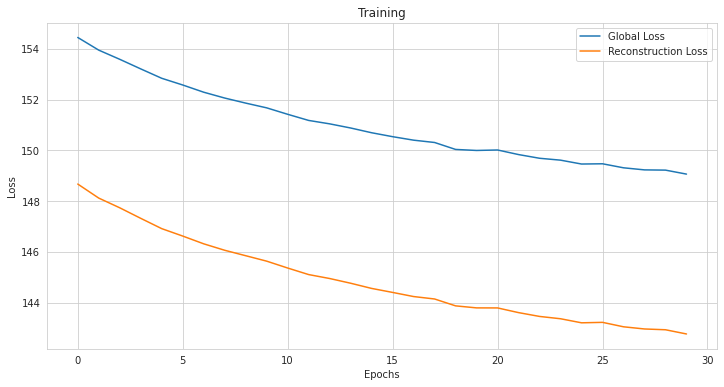

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Global Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Ahora lo usaremos para data augmentation

1/1 [==============================] - 0s 25ms/step


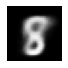

In [20]:
import random
import matplotlib.pyplot as plt

digit_size = 28
scale = 1.0
x_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
y_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
z_sample = np.array([[x_, y_]])
x_decoded = vae.decoder.predict(z_sample) # pasamos por el decoder
digit = x_decoded[0].reshape(digit_size, digit_size) # le hacemos un reshape al formato de la imagen (28x28)
plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(digit, cmap="Greys_r")
plt.show()